## Introduction - Purpose: 

The idea of the notebook is to have all the documentation for the Samarth database work to clean up the dataset and include them for analysis and creating sample use-case in one place. 

The TOC on th left can be used to guide one to relevant parts of the work. 


## Toggling the raw codes: 

In [13]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Importing Libraries and connecting to SQL:

In [6]:
import pyodbc 
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

In [3]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def open_connection(dbname,user,pwd,host_name,port ):
    conn = psycopg2.connect(database = dbname, user = user, password = pwd, host = host_name, port = port)
    print ("Connected successfully")
    return conn

In [11]:
def run_sql_code(sql_stmnt,conn) : 
    cursor = conn.cursor()
    cursor.execute( sql_stmnt )
    
    if cursor.pgresult_ptr is not None:
        sql_table = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]
        sql_table_df =  pd.DataFrame(sql_table,columns = (column_names))
    else:
        sql_table_df =  "No table rows selected"

    return(sql_table_df)

### Connecting to  SQL server 
Enter password to connect to the Samarth Staging server : 

In [9]:
dbname ="postgres"
user = "postgres"
host_name = "143.110.183.73"
port = "15432"
pwd= getpass.getpass()

········


In [12]:
conn = open_connection(dbname,user,pwd,host_name,port )

Connected successfully


In [215]:
def print_class_metric( y_train, y_pred2 ) :
    conf_mat = confusion_matrix(y_train, y_pred2)
    FN = conf_mat[0,1]
    TN = conf_mat[0,0]
    FP =conf_mat[1,0]
    TP = conf_mat[1,1]
    Average_precision =  round((TP/(TP+FP) + TN/(TN + FN))/2, 4)
    Average_recall =  round((TP/(TP+FN) + TN/(TN + FP))/2, 4)
    
    # percentages for tp/fp/tn/fn
    perc_tp = "{:.2%}".format(round(TP/(TP+FP+TN+FN), 4))
    perc_fp = "{:.2%}".format(round(FP/(TP+FP+TN+FN), 4))
    perc_tn = "{:.2%}".format(round(TN/(TP+FP+TN+FN), 4))
    perc_fn = "{:.2%}".format(round(FN/(TP+FP+TN+FN), 4))
    
    #calculate F1 score
    F1_score = round(f1_score(y_train, y_pred2), 4)
    return Average_precision, Average_recall, F1_score, perc_tp, perc_fp, perc_tn, perc_fn

def print_conf_matrix(y_train, y_pred2, modelname):
    plt.rcParams["figure.figsize"] = (6.4, 4.8)
    conf_mat = confusion_matrix(y_train, y_pred2)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix - {}'.format(modelname)) 
    ax.xaxis.set_ticklabels(['Functional', 'Non-Functional']); ax.yaxis.set_ticklabels(['Functional', 'Non-Functional'])
    print('\n')

## Data exploration: 

### Joining the required table to get required columns together : 

Sample 10 rows of the table acquired for calculating student grades for assessments :

In [37]:
sql_stmnt = ''' 
SELECT assessment_percent,
       assessment_grade,
       base.grade_number    AS subm_grade_number,
       student.grade_number AS stud_grade_number,
       subject_id,
       subject.name         AS Subject_dec,
       subject.grade_number AS Subject_grade_number,
       assessment_id,
       student_id,
       student.section      AS section,
       category,
       is_cwsn,
       admission_number,
       previous_acad_year,
       grade_year_mapping,
       deadline.date        AS submission_date,
       deadline.acad_year   AS submission_academic_year,
       CASE
         WHEN assessment_type."desc" IS NULL THEN assessment."type"
         ELSE assessment_type."desc"
       end                  AS assessment_type
FROM   student_submission base
       LEFT JOIN student
              ON base.student_id = student.id
       LEFT JOIN school
              ON student.school_id = school.id
       LEFT JOIN assessment
              ON base.assessment_id = assessment.id
       LEFT JOIN assessment_type
              ON assessment.type_v2_id = assessment_type.id
       LEFT JOIN deadline
              ON assessment.deadline_id = deadline.id
       LEFT JOIN subject
              ON base.subject_id = subject.id
LIMIT  10; 
        '''
df = run_sql_code(sql_stmnt,conn)
df

,assessment_percent,assessment_grade,subm_grade_number,stud_grade_number,subject_id,subject_dec,subject_grade_number,assessment_id,student_id,section,category,is_cwsn,admission_number,previous_acad_year,grade_year_mapping,submission_date,submission_academic_year,assessment_type
0,-1.0,C,3,4,4,Hindi,2,2,345254,A,GE,False,563,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2
1,-1.0,A,1,2,2,English,11,2,55222,A,OB,False,1256,2019-2020,[2019-2020::1],2020-07-31 23:59:00+00:00,2019-2020,SA2
2,-1.0,B,1,2,2,English,11,2,55223,A,OB,False,5436,2019-2020,[2019-2020::1],2020-07-31 23:59:00+00:00,2019-2020,SA2
3,-1.0,B,1,2,2,English,11,2,55224,A,OB,False,5686,2019-2020,[2019-2020::1],2020-07-31 23:59:00+00:00,2019-2020,SA2
4,-1.0,D,2,3,3,Maths,11,2,55225,A,OB,True,2536,2019-2020,[2019-2020::2],2020-07-31 23:59:00+00:00,2019-2020,SA2
5,-1.0,A,2,3,1,Hindi,11,2,55225,A,OB,True,2536,2019-2020,[2019-2020::2],2020-07-31 23:59:00+00:00,2019-2020,SA2
6,-1.0,A,1,2,1,Hindi,11,2,55222,A,OB,False,1256,2019-2020,[2019-2020::1],2020-07-31 23:59:00+00:00,2019-2020,SA2
7,-1.0,C,1,2,3,Maths,11,2,55222,A,OB,False,1256,2019-2020,[2019-2020::1],2020-07-31 23:59:00+00:00,2019-2020,SA2
8,-1.0,B,1,2,1,Hindi,11,2,55223,A,OB,False,5436,2019-2020,[2019-2020::1],2020-07-31 23:59:00+00:00,2019-2020,SA2
9,-1.0,B,3,4,4,Hindi,2,2,345158,A,GE,False,559,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2


#### Important columns :  
1. Assessment_percent :  Assesment grade in terms of percentage 
2. Assessment_grade :  Assessment grade in terms of grade (A,B,C,D,E) and Z (Absent) 
3. Submission_grade_number :  Grade number of the student when they submitted 
4. Student_grade_number :  Student current grade 
5. Subject_desc : subject description 
6. Subject_grade_number : Grade number obtained from Subject table (looks incorrect)
7. category :  GEN,OBC, SC etc
8. is_cswn :  Special needs of the students as defined by the state for providing benefits
9. submission_date : date when the submission was made 
10. assessment_type :  type of assessment - SA2, FA1 etc 

### Filters applied :

These filters are basic filters to remove test and inactive  students/school: 
- student.is_enabled = 't'
- school.is_active =  't'
- school.udise > 1111111111 

We can see how many rows are being removed each of the filters (and all of the filters combined):

In [44]:
Filtered_rows =  pd.DataFrame ( np.array(['None', 'student.is_enabled', 'school.is_active', 'school.udise', 'all' ]), columns = ['Filter_applied'])
Filtered_rows['count_rows'] =  np.array([11354429,6652839, 11351087, 11352492,6650036 ])
Filtered_rows['Percentage_filtered_out'] = np.round(100 - (Filtered_rows['count_rows']*100 /11354429),2)
Filtered_rows

,Filter_applied,count_rows,Percentage_filtered_out
0,None,11354429,0.00
1,student.is_enabled,6652839,41.41
2,school.is_active,11351087,0.03
3,school.udise,11352492,0.02
4,all,6650036,41.43


I'll save the above table with the filters as a temporary view. 

In [165]:
sql_stmnt = ''' 
CREATE TEMP VIEW test_view_submissions_data AS
SELECT    assessment_percent,
          assessment_grade,
          base.grade_number    AS subm_grade_number,
          student.grade_number AS stud_grade_number,
          subject_id,
          subject.NAME         AS Subject_dec,
          subject.grade_number AS Subject_grade_number,
          assessment_id,
          student_id,
          student.section AS section,
          category,
          is_cwsn,
          admission_number,
          previous_acad_year,
          grade_year_mapping,
          deadline.date      AS submission_date,
          deadline.acad_year AS submission_academic_year ,
          CASE
                    WHEN assessment_type."desc" IS NULL THEN assessment."type"
                    ELSE assessment_type."desc"
          END AS assessment_type
FROM      student_submission base
LEFT JOIN student
ON        base.student_id = student.id
LEFT JOIN school
ON        student.school_id = school.id
LEFT JOIN assessment
ON        base.assessment_id = assessment.id
LEFT JOIN assessment_type
ON        assessment.type_v2_id = assessment_type.id
LEFT JOIN deadline
ON        assessment.deadline_id = deadline.id
LEFT JOIN subject
ON        base.subject_id = subject.id
WHERE     student.is_enabled = 't'
AND       school.is_active = 't'
AND       school.udise > 1111111111;
        '''
df = run_sql_code(sql_stmnt,conn)

### Creating a columns for the grades :  

We have two columns for the grades - 
Assessment_percent : Assesment grade in terms of percentage
Assessment_grade : Assessment grade in terms of grade (A,B,C,D,E) and Z (Absent)

We need to verify if these are provided separate from each other or if they are both available at the same time for the submissions 

In [56]:
sql_stmnt = '''  SELECT percentage_blocks, count(*) AS Frequency FROM
(
SELECT 
*,
CASE 
    WHEN assessment_percent = -1 THEN -1 
    WHEN assessment_percent = 0 THEN 0 
    WHEN assessment_percent BETWEEN 0 and 10 THEN 10 
    WHEN assessment_percent  BETWEEN 10 and 20 THEN 20 
    WHEN assessment_percent  BETWEEN 20 and 30 THEN 30
    WHEN assessment_percent  BETWEEN 30 and 40 THEN 40
    WHEN assessment_percent  BETWEEN 40 and 50 THEN 50
    WHEN assessment_percent  BETWEEN 50 and 60 THEN 60
    WHEN assessment_percent  BETWEEN 60 and 70 THEN 70
    WHEN assessment_percent  BETWEEN 70 and 80 THEN 80
    WHEN assessment_percent  BETWEEN 80 and 90 THEN 90
    WHEN assessment_percent  BETWEEN 90 and 100 THEN 100
    WHEN assessment_percent IS NULL THEN NULL
    END AS percentage_blocks 
    FROM test_view_submissions_data) a 
GROUP BY percentage_blocks '''
df = run_sql_code(sql_stmnt,conn)

#### Plotting the assessment percentages : 
 Plotting a histogram of the assessment percentage column , taking 0,-1 and NULL as separate values and considering the rest in blocks of 10 

So, 0-10 is considered as 10, 10-20 as 20, 20-30 as 30 and so on: 
    

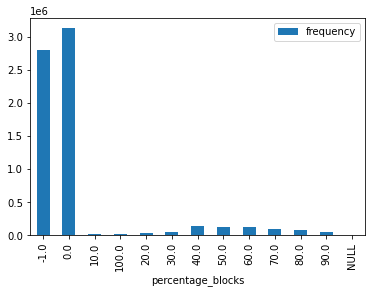

In [71]:
df["percentage_blocks"].replace({np.nan: "NULL"}, inplace=True)
df["percentage_blocks"] = df["percentage_blocks"].astype(str)
df = df.sort_values(by='percentage_blocks')
df.plot.bar(x='percentage_blocks', y='frequency')


We can see that most of the values are in 0,-1 while the rest are distributed amongst the 10 blocks. 
We can look at what are the grades provided for these values, specifically what are the grades when it is in (0,-1 NULL) and what are the grades when assessment_percentage is not in these values i.e. it is in one of the blocks

In [72]:
sql_stmnt = '''SELECT percentage_blocks,assessment_grade, count(*) AS Frequency FROM
(
SELECT 
*,
CASE 
    WHEN assessment_percent = -1 THEN -1 
    WHEN assessment_percent = 0 THEN 0 
    WHEN assessment_percent BETWEEN 0 and 10 THEN 10 
    WHEN assessment_percent  BETWEEN 10 and 20 THEN 20 
    WHEN assessment_percent  BETWEEN 20 and 30 THEN 30
    WHEN assessment_percent  BETWEEN 30 and 40 THEN 40
    WHEN assessment_percent  BETWEEN 40 and 50 THEN 50
    WHEN assessment_percent  BETWEEN 50 and 60 THEN 60
    WHEN assessment_percent  BETWEEN 60 and 70 THEN 70
    WHEN assessment_percent  BETWEEN 70 and 80 THEN 80
    WHEN assessment_percent  BETWEEN 80 and 90 THEN 90
    WHEN assessment_percent  BETWEEN 90 and 100 THEN 100
    WHEN assessment_percent IS NULL THEN NULL
    END AS percentage_blocks 
    FROM test_view_submissions_data) a 
GROUP BY percentage_blocks,assessment_grade '''

df = run_sql_code(sql_stmnt,conn)

In [73]:
df["percentage_blocks"].replace({np.nan: "NULL"}, inplace=True)
df["percentage_blocks"] = df["percentage_blocks"].astype(str)
df_pivot = df.pivot(index='percentage_blocks', columns='assessment_grade', values='frequency').fillna(0)

We plot all the Grades present for each of the percentage values: 

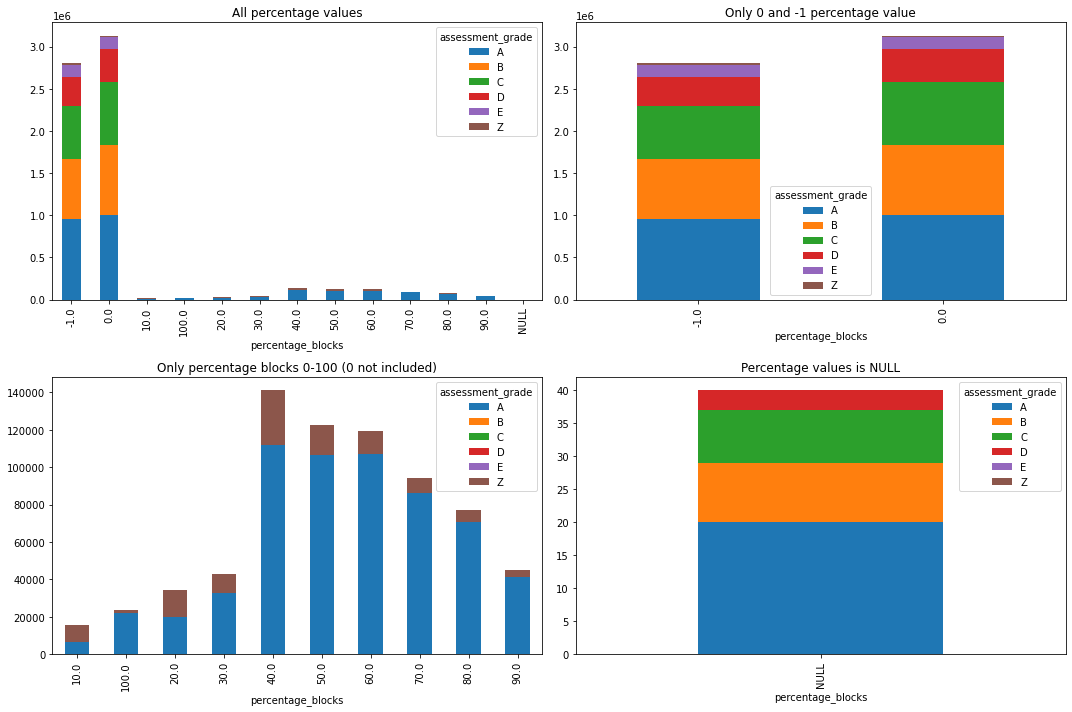

In [129]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
df_pivot.plot(ax=axes[0,0], kind='bar', stacked=True,title= 'All percentage values')
df_pivot[df_pivot.index.isin(['-1.0', '0.0'])].plot(ax=axes[0,1], kind='bar', stacked=True,title= 'Only 0 and -1 percentage value')
df_pivot[~df_pivot.index.isin(['-1.0', '0.0','NULL'])].plot( ax=axes[1,0],kind='bar', stacked=True, title= 'Only percentage blocks 0-100 (0 not included)')
df_pivot[df_pivot.index.isin(['NULL'])].plot( ax=axes[1,1], kind='bar', stacked=True, title= 'Percentage values is NULL')
fig.tight_layout()
plt.show()

###### From looking at the grade distribution for the percentage values, we can say that when percentage value is 0,-1 or NULL, the grades are provided i.e. we must look at assessment_grade which will have values A,B,C,D,E or Z(if absent)

###### In other cases ,we must consider the assessment_percentage and not consider the grades; when the percentage is provided, then the grades are either A or Z 


#### Connecting assessment_percentage and assessment_grade: 

Looking at the how grades are allocated for assessment percentage in historical work: 

In [184]:
sql_stmnt =  '''SELECT DISTINCT assessment_grade, assessment_pct_bin, assessment_pct_avg 
FROM student_assessments_temp
ORDER BY assessment_grade '''
df = run_sql_code(sql_stmnt,conn)
df

,assessment_grade,assessment_pct_bin,assessment_pct_avg
0,A,80-100,90.0
1,B,65-79,72.0
2,C,50-64,57.0
3,D,35-49,42.0
4,E,1-34,17.0
5,Z,None,NaN


We can see the bins decided for each grade. 
Assessment percentage average is the average of the minimum and maximum of the range provided for the assessment percent bins for each grade

We can allocate the grades for the percentage scores in our data and look at what the actual average percentage is for those buckets : 

In [185]:
sql_stmnt = '''select assessment_grade_all,AVG(assessment_percent) as mean_perc, count(*) as freq from 
(
    select 
    CASE WHEN assessment_percent in  (0,-1) THEN  assessment_grade
     WHEN assessment_percent is null THEN assessment_grade
     WHEN assessment_percent BETWEEN 80 AND 100 THEN  'A'
     WHEN assessment_percent BETWEEN 65 AND 80 THEN  'B'
     WHEN assessment_percent BETWEEN 50 AND 65 THEN  'C'
     WHEN assessment_percent BETWEEN 35 AND 50 THEN  'D'
     WHEN assessment_percent BETWEEN 0 AND 35 THEN 'E' 
    END AS assessment_grade_all,
    CASE WHEN (assessment_percent not in (0,-1) and assessment_percent is not NULL) THEN  1
    ELSE 0 
    END AS assessment_percent_all,* from test_view_submissions_data ) ads
where assessment_percent not in (0,-1)  
and assessment_percent is not null 
group by assessment_grade_all'''
df1 = run_sql_code(sql_stmnt,conn)

In [186]:
sql_stmnt = '''SELECT assessment_grade_all,
        (MAX(CASE WHEN Half1 = 1 THEN assessment_percent END) + 
        MIN(CASE WHEN Half2 = 1 THEN assessment_percent END)) / 2.0 as median
        FROM 
(select assessment_grade_all,assessment_percent,
NTILE(4) OVER(PARTITION BY assessment_grade_all ORDER BY assessment_percent) as half1,
NTILE(4) OVER(PARTITION BY assessment_grade_all ORDER BY assessment_percent DESC) as half2
FROM 
(
    select 
    CASE WHEN assessment_percent in  (0,-1) THEN  assessment_grade
     WHEN assessment_percent is null THEN assessment_grade
     WHEN assessment_percent BETWEEN 80 AND 100 THEN  'A'
     WHEN assessment_percent BETWEEN 65 AND 80 THEN  'B'
     WHEN assessment_percent BETWEEN 50 AND 65 THEN  'C'
     WHEN assessment_percent BETWEEN 35 AND 50 THEN  'D'
     WHEN assessment_percent BETWEEN 0 AND 35 THEN 'E' 
    END AS assessment_grade_all,
    CASE WHEN (assessment_percent not in (0,-1) and assessment_percent is not NULL) THEN  1
    ELSE 0 
    END AS assessment_percent_all,* from test_view_submissions_data ) ads
where assessment_percent not in (0,-1)  
and assessment_percent is not null 
)a
GROUP BY assessment_grade_all'''
df2 = run_sql_code(sql_stmnt,conn)

In [187]:
df1['mean_perc']= np.round(df1['mean_perc'],2)
df1 = df1.rename(columns={'mean_perc': 'mean_perc_from_data'})
df2['median']= np.round(df2['median'],2)
df2 = df2.rename(columns={'median': 'median_perc_from_data'})
df3 = pd.merge(df, df1,  how='left', left_on=['assessment_grade'], right_on = ['assessment_grade_all'])
df3 = df3[['assessment_grade','assessment_pct_bin','assessment_pct_avg','mean_perc_from_data','freq']]
df4 = pd.merge(df3, df2,  how='left', left_on=['assessment_grade'], right_on = ['assessment_grade_all'])
df4 = df4[['assessment_grade','assessment_pct_bin','assessment_pct_avg','mean_perc_from_data','median_perc_from_data','freq']]

In [188]:
df4

,assessment_grade,assessment_pct_bin,assessment_pct_avg,mean_perc_from_data,median_perc_from_data,freq
0,A,80-100,90.0,87.41,87.06,77722.0
1,B,65-79,72.0,71.35,71.50,120875.0
2,C,50-64,57.0,56.85,56.50,171309.0
3,D,35-49,42.0,41.96,41.95,189812.0
4,E,1-34,17.0,24.54,25.50,156191.0
5,Z,None,NaN,NaN,NaN,NaN


As we can see, the mean/median of percentage obtained by the students is close to the approximate average of the bins considered except for Grade A and E 

For grade A,  its lower than the middle of the bin:  87 instead of 90 

For grade Z, its higher than the middle of the bin:  25.5 instead of 17 
   
######  We can assign percentage for each of the grade to have a column with percentages  for all rows : 

WHEN assessment_grade = 'A' THEN 87

WHEN assessment_grade = 'B' THEN 72

WHEN assessment_grade = 'C' THEN 57

WHEN assessment_grade = 'D' THEN 42

WHEN assessment_grade = 'E' THEN 25.5

WHEN assessment_grade = 'Z' THEN NULL


###### Similarly, we can assign grades for the percentage values to have a column with grades for the column

We can assign grades based on the buckets pre-defined earlier, i.e.: 
    
WHEN assessment_percent BETWEEN 80 AND 100 THEN  'A'

WHEN assessment_percent BETWEEN 65 AND 80 THEN  'B'

WHEN assessment_percent BETWEEN 50 AND 65 THEN  'C'

WHEN assessment_percent BETWEEN 35 AND 50 THEN  'D'

WHEN assessment_percent BETWEEN 0 AND 35 THEN 'E' 

I created a view including all the above columns into the table.

In [5]:
sql_stmnt = '''    
CREATE TEMP VIEW test_view_submissions_data AS
select assessment_percent,
    assessment_grade,
    CASE WHEN assessment_percent in  (0,-1) THEN  assessment_grade
     WHEN assessment_percent is null THEN assessment_grade
     WHEN assessment_percent BETWEEN 80 AND 100 THEN  'A'
     WHEN assessment_percent BETWEEN 65 AND 80 THEN  'B'
     WHEN assessment_percent BETWEEN 50 AND 65 THEN  'C'
     WHEN assessment_percent BETWEEN 35 AND 50 THEN  'D'
     WHEN assessment_percent BETWEEN 0 AND 35 THEN 'E' 
    END AS assessment_grade_all,
    CASE WHEN (assessment_percent not in (0,-1) and assessment_percent is not NULL) THEN  assessment_percent
     WHEN assessment_grade = 'A' THEN 87.5
     WHEN assessment_grade = 'B' THEN 72
     WHEN assessment_grade = 'C' THEN 57
     WHEN assessment_grade = 'D' THEN 42
     WHEN assessment_grade = 'E' THEN 24
     WHEN assessment_grade = 'Z' THEN NULL
    END AS assessment_percent_all,

    base.grade_number as subm_grade_number,
    student.grade_number as stud_grade_number,
    subject.grade_number as Subject_grade_number,
    subject_id,
    subject.name as Subject_desc,
    assessment_id,
    student_id,
    student.section as section,
    category,
    is_cwsn,
    admission_number,
    previous_acad_year,
    grade_year_mapping,
    deadline.date as submission_date, 
    deadline.acad_year as submission_academic_year ,
    CASE WHEN  assessment_type."desc" IS NULL THEN assessment."type" ELSE assessment_type."desc" 
    END AS assessment_type 
     from student_submission base
    left join student on base.student_id  = student.id
        left join school on student.school_id = school.id
        left join assessment on base.assessment_id =  assessment.id   
        left join assessment_type on  assessment.type_v2_id  = assessment_type.id
        left join deadline on assessment.deadline_id =  deadline.id
        left join subject on base.subject_id =  subject.id 
        where student.is_enabled = 't'
            and school.is_active =  't'
            and school.udise > 1111111111 ;'''

df = run_sql_code(sql_stmnt,conn)

#### Grade number issues : 

Looking again at a sample 10 rows: 


We see there are 3 columns for the class (grade_number -  columns 5,6,7):

- Submission_grade_number:  This is the grade for which the assessment is designed for (from student submission table )
- Stud_grade_number : This is the grade where the student is studying in currently (from the student table)
- Subject_grade_number : This is the grade for which the assessment is designed for (from the subject table)
    
We see that in the sample, these columns have different values. We expect the subm_grade_number and student_grade_number to have different value based on when the student has submitted the assesment 

The current academic year is 2021-2022 and I created a yr_diff column (Stud_grade_number - Submission_grade_number) to calculate how many years ago the student submitted the assesments 

The subject grade number values however seem to be unreliable 

In [218]:
sql_stmnt = '''    
SELECT *, stud_grade_number - subm_grade_number  as yr_diff FROM  test_view_submissions_data LIMIT 10;
'''
df = run_sql_code(sql_stmnt,conn)
df

,assessment_percent,assessment_grade,assessment_grade_all,assessment_percent_all,subm_grade_number,stud_grade_number,subject_grade_number,subject_id,subject_desc,assessment_id,...,section,category,is_cwsn,admission_number,previous_acad_year,grade_year_mapping,submission_date,submission_academic_year,assessment_type,yr_diff
0,-1.0,D,D,42.0,6,8,11,3,Maths,2,...,A,GE,False,549,2019-2020,[2019-2020::6],2020-07-31 23:59:00+00:00,2019-2020,SA2,2
1,-1.0,D,D,42.0,6,8,11,3,Maths,2,...,A,SC,False,550,2019-2020,[2019-2020::6],2020-07-31 23:59:00+00:00,2019-2020,SA2,2
2,-1.0,B,B,72.0,6,8,11,3,Maths,2,...,A,GE,False,555,2019-2020,[2019-2020::6],2020-07-31 23:59:00+00:00,2019-2020,SA2,2
3,-1.0,B,B,72.0,6,8,11,3,Maths,2,...,A,SC,False,552,2019-2020,[2019-2020::6],2020-07-31 23:59:00+00:00,2019-2020,SA2,2
4,-1.0,A,A,87.5,6,8,11,3,Maths,2,...,A,GE,False,551,2019-2020,[2019-2020::6],2020-07-31 23:59:00+00:00,2019-2020,SA2,2
5,-1.0,A,A,87.5,3,5,11,1,Hindi,2,...,A,GE,False,2781,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2,2
6,-1.0,A,A,87.5,2,4,11,1,Hindi,2,...,A,GE,False,223,2019-2020,[2019-2020::2],2020-07-31 23:59:00+00:00,2019-2020,SA2,2
7,-1.0,A,A,87.5,1,3,11,2,English,2,...,A,SC,False,613,2019-2020,[2019-2020::2],2020-07-31 23:59:00+00:00,2019-2020,SA2,2
8,-1.0,B,B,72.0,2,4,11,2,English,2,...,A,SC,False,605,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2,2
9,-1.0,D,D,42.0,7,9,1,6,English,2,...,A,ST,False,150,2019-2020,[2019-2020::7],2020-07-31 23:59:00+00:00,2019-2020,SA2,2


We can check what are the yr_diff values present for each academic year :  

In [205]:
sql_stmnt = '''   select submission_academic_year, yr_diff, count(*) from 
(select *, stud_grade_number - subm_grade_number  as yr_diff from test_view_submissions_data) as a
group by submission_academic_year, yr_diff'''
df = run_sql_code(sql_stmnt,conn)

In [211]:
df1 = df.sort_values(by='count', ascending = False)
df1

,submission_academic_year,yr_diff,count
8,2020-2021,1,5942800
3,2019-2020,2,535438
12,2020-2021,0,98828
18,2019-2020,1,67669
14,2020-2021,2,3397
0,2019-2020,0,983
19,2019-2020,3,276
16,2020-2021,-1,190
10,2020-2021,3,140
5,2020-2021,4,113


We see that there are various year_diff values for each submission_academic_year pointing to some mimatch between the grades_columns

#### Same submission year but different grades for same student:

For the same academic year, the same student is submitting the assessments for the same subjects of two differnt grades. 
Also, he is getting same grade in them.

In [262]:
sql_stmnt = '''select base.* from test_view_submissions_data base 
inner join 
(select * from
(select student_id,assessment_id,Subject_desc,subm_grade_number, count(distinct assessment_grade_all) as count_assessment, count(*) as count_rows from test_view_submissions_data
group by  student_id,assessment_id,Subject_desc,subm_grade_number ) a
where count_assessment = 1
and count_rows > 1
limit 20 ) a 
on base.student_id =  a.student_id
and base.assessment_id  =  a.assessment_id
and base.Subject_desc = a.Subject_desc
and base.subm_grade_number  = a.subm_grade_number
order by student_id,assessment_id,Subject_desc,stud_grade_number;'''

df = run_sql_code(sql_stmnt,conn)

In [265]:
df_multi_grade =  df 
df_multi_grade.loc[0:10,:]

,assessment_percent,assessment_grade,assessment_grade_all,assessment_percent_all,subm_grade_number,stud_grade_number,subject_desc,assessment_id,student_id,section,category,is_cwsn,admission_number,previous_acad_year,grade_year_mapping,submission_date,submission_academic_year,assessment_type
0,-1.0,B,B,72.0,3,5,Hindi,16,1311,A,SC,False,96,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2
1,-1.0,B,B,72.0,4,5,Hindi,16,1311,A,SC,False,96,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2
2,-1.0,B,B,72.0,3,5,Hindi,16,1314,A,SC,False,97,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2
3,-1.0,B,B,72.0,4,5,Hindi,16,1314,A,SC,False,97,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2
4,-1.0,B,B,72.0,4,5,English,16,1458,A,SC,False,299,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2
5,-1.0,B,B,72.0,3,5,English,16,1458,A,SC,False,299,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2
6,-1.0,A,A,87.5,3,5,Maths,16,1458,A,SC,False,299,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2
7,-1.0,A,A,87.5,4,5,Maths,16,1458,A,SC,False,299,2019-2020,[2019-2020::3],2020-07-31 23:59:00+00:00,2019-2020,SA2
8,-1.0,A,A,87.5,1,3,English,16,1462,A,SC,False,315,2019-2020,[2019-2020::1],2020-07-31 23:59:00+00:00,2019-2020,SA2
9,-1.0,A,A,87.5,2,3,English,16,1462,A,SC,False,315,2019-2020,[2019-2020::1],2020-07-31 23:59:00+00:00,2019-2020,SA2


#### Different grades for same student subject assessment submission : 

For the same assessment and grade(class) , the student is having different rows with different marks. 

In [221]:
sql_stmnt = ''' select base.* from test_view_submissions_data base 
inner join 
(select * from
(select student_id,assessment_id,Subject_desc,stud_grade_number, count(distinct assessment_grade_all) as count_assessment from test_view_submissions_data
group by  student_id,assessment_id,Subject_desc,stud_grade_number ) a
where count_assessment > 1
limit 20 ) a 
on base.student_id =  a.student_id
and base.assessment_id  =  a.assessment_id
and base.Subject_desc = a.Subject_desc
and base.stud_grade_number  = a.stud_grade_number
order by student_id,assessment_id,subject_id,stud_grade_number;'''
df = run_sql_code(sql_stmnt,conn)

In [224]:
df[['student_id','assessment_id','subject_id','subject_desc','stud_grade_number','assessment_grade_all','assessment_percent_all','submission_date','submission_academic_year','assessment_type']].loc[0:10,]

,student_id,assessment_id,subject_id,subject_desc,stud_grade_number,assessment_grade_all,assessment_percent_all,submission_date,submission_academic_year,assessment_type
0,879,16,2,English,8,C,57.0,2020-07-31 23:59:00+00:00,2019-2020,SA2
1,879,16,6,English,8,D,42.0,2020-07-31 23:59:00+00:00,2019-2020,SA2
2,882,16,2,English,8,B,72.0,2020-07-31 23:59:00+00:00,2019-2020,SA2
3,882,16,6,English,8,C,57.0,2020-07-31 23:59:00+00:00,2019-2020,SA2
4,884,16,1,Hindi,8,C,57.0,2020-07-31 23:59:00+00:00,2019-2020,SA2
5,884,16,5,Hindi,8,B,72.0,2020-07-31 23:59:00+00:00,2019-2020,SA2
6,886,16,1,Hindi,8,D,42.0,2020-07-31 23:59:00+00:00,2019-2020,SA2
7,886,16,5,Hindi,8,C,57.0,2020-07-31 23:59:00+00:00,2019-2020,SA2
8,890,16,2,English,8,C,57.0,2020-07-31 23:59:00+00:00,2019-2020,SA2
9,890,16,6,English,8,D,42.0,2020-07-31 23:59:00+00:00,2019-2020,SA2


We see that the subject id is differing for these cases. There is some subject id mapping issue as the same subject for the same class is getting mapped to different ids and getting different scores in the assessments

In [6]:
sql_stmnt = '''select count_assessment,count(*) from 
(select student_id,assessment_id,Subject_desc,subm_grade_number, count(distinct assessment_grade_all) as count_assessment, count(*) as count_rows from test_view_submissions_data
group by  student_id,assessment_id,Subject_desc,subm_grade_number ) a
group by count_assessment;'''

df = run_sql_code(sql_stmnt,conn)


In [7]:
df.sort_values('count_assessment')

,count_assessment,count
0,1,6439793
2,2,63319
1,3,9


Very rarely, do we have the issue of multiple grades for the same subject student year: 

In [80]:
round(63319/(6439793+63319 +9),3)

0.01

#### Creating table at required level: 

We finally want a table at the student_id, grade, assesment, subject level with scores for it.  
However there is duplication happening at this level with most of it cause by the above subject id issue: 

In [ ]:
##### Creation of view with distinct :  

In [19]:
sql_stmnt = ''' select counts,count_subjects, count(*) from 

(SELECT assessment_percent,
    assessment_grade,
     assessment_grade_all,
    assessment_percent_all,
    subm_grade_number,
    stud_grade_number,
    Subject_desc,
    assessment_id,
    student_id,
    section,
    category,
    is_cwsn,
    admission_number,
    previous_acad_year,
    grade_year_mapping,
    submission_date, 
    submission_academic_year ,
    assessment_type, count(*) as counts, count(distinct subject_id) as count_subjects FROM

(select  assessment_percent,
    assessment_grade,
    CASE WHEN assessment_percent in  (0,-1) THEN  assessment_grade
     WHEN assessment_percent is null THEN assessment_grade
     WHEN assessment_percent BETWEEN 80 AND 100 THEN  'A'
     WHEN assessment_percent BETWEEN 65 AND 80 THEN  'B'
     WHEN assessment_percent BETWEEN 50 AND 65 THEN  'C'
     WHEN assessment_percent BETWEEN 35 AND 50 THEN  'D'
     WHEN assessment_percent BETWEEN 0 AND 35 THEN 'E' 
    END AS assessment_grade_all,
    CASE WHEN (assessment_percent not in (0,-1) and assessment_percent is not NULL) THEN  assessment_percent
     WHEN assessment_grade = 'A' THEN 87.5
     WHEN assessment_grade = 'B' THEN 72
     WHEN assessment_grade = 'C' THEN 57
     WHEN assessment_grade = 'D' THEN 42
     WHEN assessment_grade = 'E' THEN 24
     WHEN assessment_grade = 'Z' THEN NULL
    END AS assessment_percent_all,

    base.grade_number as subm_grade_number,
    student.grade_number as stud_grade_number,
    --subject.grade_number as Subject_grade_number,
    subject_id,
    subject.name as Subject_desc,
    assessment_id,
    student_id,
    student.section as section,
    category,
    is_cwsn,
    admission_number,
    previous_acad_year,
    grade_year_mapping,
    deadline.date as submission_date, 
    deadline.acad_year as submission_academic_year ,
    CASE WHEN  assessment_type."desc" IS NULL THEN assessment."type" ELSE assessment_type."desc" 
    END AS assessment_type 
     from student_submission base
    left join student on base.student_id  = student.id
        left join school on student.school_id = school.id
        left join assessment on base.assessment_id =  assessment.id   
        left join assessment_type on  assessment.type_v2_id  = assessment_type.id
        left join deadline on assessment.deadline_id =  deadline.id
        left join subject on base.subject_id =  subject.id 
        where student.is_enabled = 't'
            and school.is_active =  't'
            and school.udise > 1111111111) ads 
GROUP BY assessment_percent,
    assessment_grade,
     assessment_grade_all,
    assessment_percent_all,
    subm_grade_number,
    stud_grade_number,
    Subject_desc,
    assessment_id,
    student_id,
    section,
    category,
    is_cwsn,
    admission_number,
    previous_acad_year,
    grade_year_mapping,
    submission_date, 
    submission_academic_year ,
    assessment_type) a
group by counts,count_subjects '''
df = run_sql_code(sql_stmnt,conn)

Looking at how much of the current data follows the correct level without duplication: 

In [55]:
print('Percentage of the view that is not duplicated at all in the tables: ',df.loc[df['counts']==1,'count'].values[0]*100/df['count'].values.sum())

Percentage of the view that is not duplicated at all in the tables:  98.7594862569297


We can also calculate the proportion of this that is caused due to incorrect subject mapping.

In [60]:
duplicated_rows = df.loc[df['counts']!=1,'count'].sum()

In [64]:
df_duplicated = df.loc[df['counts']!=1,:]

In [76]:
df_duplicated.loc[df['counts']== df['count_subjects'],'count'].sum()/duplicated_rows

0.9433327604409635

To summarize, the duplication issue affects only 1.24 % of the rows. 94% of this duplication is caused by different subject ids being mapped to same subject description

In [ ]:
df['count'].values.sum(),duplicated_rows

In [12]:
sql_stmnt = ''' DROP  view test_view_submissions_data;
CREATE TEMP table test_view_submissions_data AS
select distinct assessment_percent,
    assessment_grade,
    CASE WHEN assessment_percent in  (0,-1) THEN  assessment_grade
     WHEN assessment_percent is null THEN assessment_grade
     WHEN assessment_percent BETWEEN 80 AND 100 THEN  'A'
     WHEN assessment_percent BETWEEN 65 AND 80 THEN  'B'
     WHEN assessment_percent BETWEEN 50 AND 65 THEN  'C'
     WHEN assessment_percent BETWEEN 35 AND 50 THEN  'D'
     WHEN assessment_percent BETWEEN 0 AND 35 THEN 'E' 
    END AS assessment_grade_all,
    CASE WHEN (assessment_percent not in (0,-1) and assessment_percent is not NULL) THEN  assessment_percent
     WHEN assessment_grade = 'A' THEN 87.5
     WHEN assessment_grade = 'B' THEN 72
     WHEN assessment_grade = 'C' THEN 57
     WHEN assessment_grade = 'D' THEN 42
     WHEN assessment_grade = 'E' THEN 24
     WHEN assessment_grade = 'Z' THEN NULL
    END AS assessment_percent_all,

    base.grade_number as subm_grade_number,
    student.grade_number as stud_grade_number,
    --subject.grade_number as Subject_grade_number,
    --subject_id,
    subject.name as Subject_desc,
    assessment_id,
    student_id,
    student.section as section,
    category,
    is_cwsn,
    admission_number,
    previous_acad_year,
    grade_year_mapping,
    deadline.date as submission_date, 
    deadline.acad_year as submission_academic_year ,
    CASE WHEN  assessment_type."desc" IS NULL THEN assessment."type" ELSE assessment_type."desc" 
    END AS assessment_type 
     from student_submission base
    left join student on base.student_id  = student.id
        left join school on student.school_id = school.id
        left join assessment on base.assessment_id =  assessment.id   
        left join assessment_type on  assessment.type_v2_id  = assessment_type.id
        left join deadline on assessment.deadline_id =  deadline.id
        left join subject on base.subject_id =  subject.id 
        where student.is_enabled = 't'
            and school.is_active =  't'
            and school.udise > 1111111111 '''

df = run_sql_code(sql_stmnt,conn)


In [15]:
sql_stmnt = '''select count_assessment,count_rows,count(*) from 
(select student_id,assessment_id,Subject_desc,subm_grade_number, count(distinct assessment_percent_all) as count_assessment, count(*) as count_rows from test_view_submissions_data
where assessment_percent_all IS NOT NULL
group by  student_id,assessment_id,Subject_desc,subm_grade_number ) a
group by count_assessment,count_rows;'''

df = run_sql_code(sql_stmnt,conn)
df

,count_assessment,count_rows,count
0,1,1,6397456
1,3,3,9
2,2,2,62829
3,1,2,1


In [16]:
sql_stmnt = ''' select base.* from test_view_submissions_data base 
inner join 
(select * from
(select student_id,assessment_id,Subject_desc,subm_grade_number, count(distinct assessment_percent_all) as count_assessment, count(*) as count_rows from test_view_submissions_data
where assessment_percent_all IS NOT NULL
group by  student_id,assessment_id,Subject_desc,subm_grade_number ) a
where count_assessment = 1
and count_rows = 2 ) a 
on base.student_id =  a.student_id
and base.assessment_id  =  a.assessment_id
and base.Subject_desc = a.Subject_desc
and base.subm_grade_number  = a.subm_grade_number
order by student_id,assessment_id,Subject_desc,stud_grade_number; '''
df = run_sql_code(sql_stmnt,conn)
df

,assessment_percent,assessment_grade,assessment_grade_all,assessment_percent_all,subm_grade_number,stud_grade_number,subject_desc,assessment_id,student_id,section,category,is_cwsn,admission_number,previous_acad_year,grade_year_mapping,submission_date,submission_academic_year,assessment_type
0,49.4,Z,D,49.4,9,10,Hindi,170,782141,B,GE,False,6609,2019-2020,[2019-2020::9],2021-01-06 19:30:00+00:00,2020-2021,T2-9-12
1,49.4,A,D,49.4,9,10,Hindi,170,782141,B,GE,False,6609,2019-2020,[2019-2020::9],2021-01-06 19:30:00+00:00,2020-2021,T2-9-12


In [ ]:
sql_stmnt = '''select count_rows,count(*) from 
(select student_id,assessment_id,Subject_desc,subm_grade_number, count(distinct assessment_grade_all) as count_assessment, count(*) as count_rows from test_view_submissions_data
group by  student_id,assessment_id,Subject_desc,subm_grade_number ) a
group by count_rows;'''
df1 = run_sql_code(sql_stmnt,conn)
df1

#### Assessments not mapped to LO table: 

In [249]:
sql_stmnt = '''select count(distinct assessment_id ) from test_view_submissions_data base '''
df1 = run_sql_code(sql_stmnt,conn)

sql_stmnt = '''select count(distinct assessment_id ) from test_view_submissions_data base 
where assessment_id not in (
    select distinct (assessment_id)
        from lo_assessment inner join lo 
            on lo_assessment.lo_id = lo.id
    )'''
df2 = run_sql_code(sql_stmnt,conn)

Number of assessments in the main table: 

In [250]:
df1

,count
0,174


Number of assessments not mapped to LO table: 

In [251]:
df2

,count
0,57


In [252]:
round(df2.loc[0,'count']/df1.loc[0,'count'],4) * 100

32.76

#### Students not mapped to attendance table: 

In [240]:
sql_stmnt = '''select count(distinct student_id ) from test_view_submissions_data base '''
df1 = run_sql_code(sql_stmnt,conn)

sql_stmnt = '''select count(distinct student_id ) from test_view_submissions_data base 
where student_id not in 
(select distinct student_id from attendance)
'''
df2 = run_sql_code(sql_stmnt,conn)

The number of students available in the base tables: 

In [241]:
df1

,count
0,452771


Number of students for which attendance details are available: 

In [242]:
df2

,count
0,252965


Percentage not available: 

In [247]:
round(df2.loc[0,'count']/df1.loc[0,'count'],4)*100

55.87